In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mat
plt.rc('font', family='NanumBarunGothic')
mat.rcParams['axes.unicode_minus'] = False

## **EDA_기상데이터**

## **데이터 형태 확인**

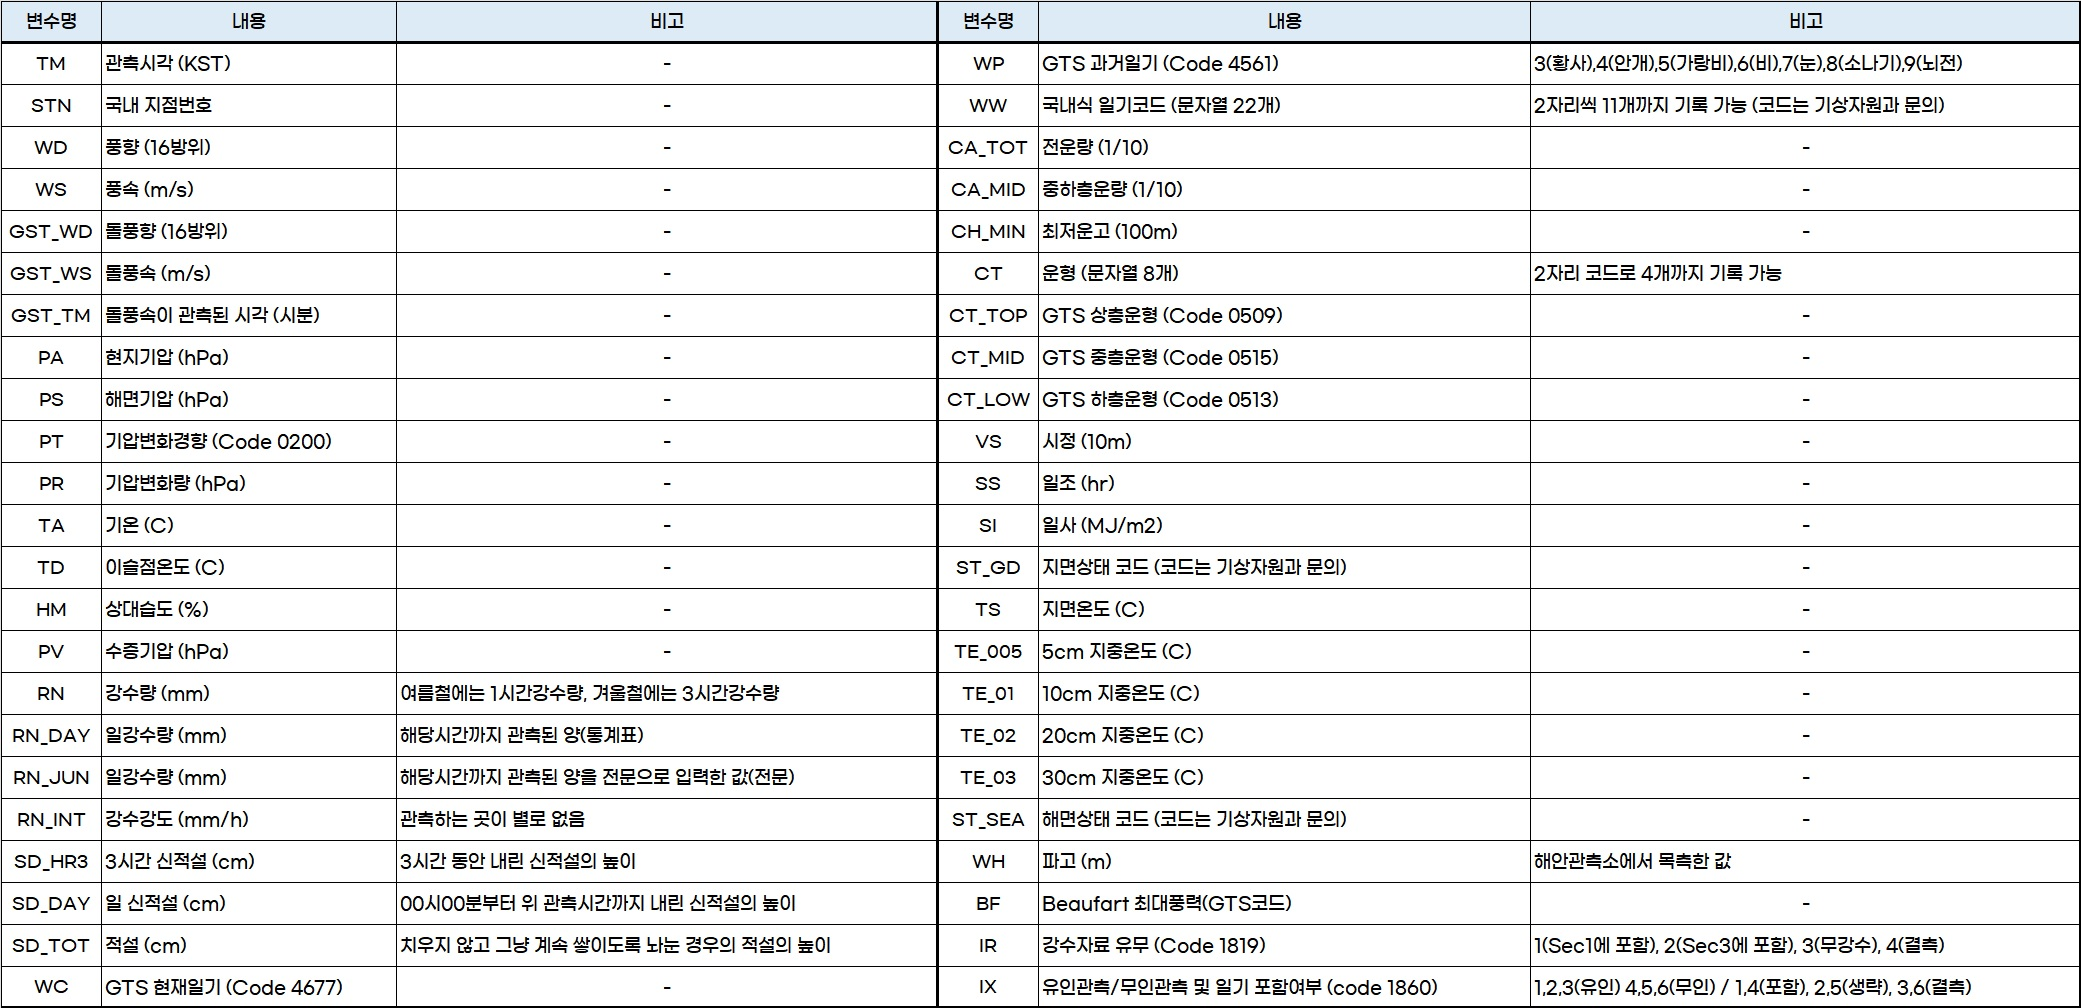

본 데이터는 2가지 특징을 가지고 있다.

1. **1시간 단위로 관측됨**
  * 전력 수급 데이터는 5분 단위로 제공되기 때문에 1시간 단위로 관측되는 기상 데이터와 샘플간의 간격이 맞지 않는다.
2. **각 지역별로 관측됨**
  * 전력 수급 데이터는 전국 단위로 제공되기 때문에 지역별 관측치에서 대표값을 선정하는 것이 필요할 것으로 보임

In [ ]:
# 데이터 불러오기
import pandas as pd
weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/weather_20130101_20230515.csv')

In [ ]:
# 데이터 형태 확인
print('기상 데이터는 {}개의 샘플과 {}개의 특성으로 이루어진 2차원 데이터입니다.'.format(weather.count(), len(weather.columns)))

기상 데이터는 8590011개의 샘플과 49개의 특성으로 이루어진 2차원 데이터입니다.


## **이상치 (-9, -99, '-')의 분포 확인**

In [ ]:
# 컬럼별/연도별 (-9, -99, '-')의 값을 가지는 행의 비율
# 본 작업을 통해 전체 기상관측 데이터 중 사용 가능한 특성이 얼마나 되는지를 파악함

import pandas as pd
from tqdm import tqdm

column_list = list(weather.columns.values)
column_list.remove('datetime')
column_list.insert(0, 'YEAR')
null_value_df = pd.DataFrame(columns = column_list)
null_value_df['YEAR'] = [year for year in range(2013, 2024)]

for row_number in tqdm(range(null_value_df.shape[0]), desc = '행단위'):
  for col_number in tqdm(range(1, 49), desc = '열단위'):
    null_value_df.iat[row_number, col_number] = len(weather[(pd.to_datetime(weather['datetime']).dt.year==row_number+2013)\
                                                           &((weather[column_list[col_number]]==-9)\
                                                            |(weather[column_list[col_number]]==-99)\
                                                            |(weather[column_list[col_number]]=='-'))])\
                                                /len(weather[pd.to_datetime(weather['datetime']).dt.year==row_number+2013])
null_value_df.to_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/null_value_df.csv')

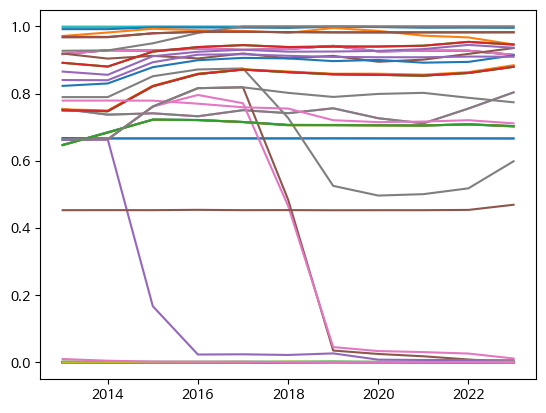

In [ ]:
import pandas as pd
column_list = list(null_value_df.columns.values)

for column in column_list[1:]:
  plt.plot(null_value_df.YEAR, null_value_df[column], label = column)

데이터의 특성의 개수는 49개이지만 -9, -99 혹은 '-'의 비율이 낮아 모델 학습에 사용할 수 있는 컬럼은 15개 가량으로 적다.

In [108]:
# 2023년 기준 전체 행에서 -9, -99 혹은 '-'의 값을 가지는 비율이 너무 높은 열은 사용에서 제외

available_column_list = null_value_df[null_value_df['YEAR']==2023].melt().drop(0, axis=0).sort_values('value').reset_index(drop = True)
available_column_list.columns = ['variable', 'ratio']

## 특정 위치의 배경색 바꾸기
def draw_color_cell(x,color):
    color = f'background-color:{color}'
    return color

from IPython.display import display_html
df1_styler =available_column_list.iloc[:12,:].style.set_table_attributes("style='display:inline'").set_caption('1위 ~ 12위').applymap(draw_color_cell,color='#ff9090',subset=pd.IndexSlice[[i for i in range(0, 12)],['variable', 'ratio']])
df2_styler =available_column_list.iloc[12:24,:].style.set_table_attributes("style='display:inline'").set_caption('13위 ~ 24위').applymap(draw_color_cell,color='#ff9090',subset=pd.IndexSlice[[12, 13, 14],['variable', 'ratio']])
df3_styler =available_column_list.iloc[24:36,:].style.set_table_attributes("style='display:inline'").set_caption('25위 ~ 36위')
df4_styler =available_column_list.iloc[36:48,:].style.set_table_attributes("style='display:inline'").set_caption('37위 ~ 48위')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_()+df4_styler._repr_html_(), raw=True)

,variable,ratio
0,STN_ID,0.000000
1,STN,0.000000
2,PS_hPa,0.000013
3,PA_hPa,0.000022
4,IR_nan,0.000240
5,CA_TOT,0.000487
6,TA_C,0.000528
7,WS_m/s,0.001069
8,PV_hPa,0.001136
9,HM_%,0.001149


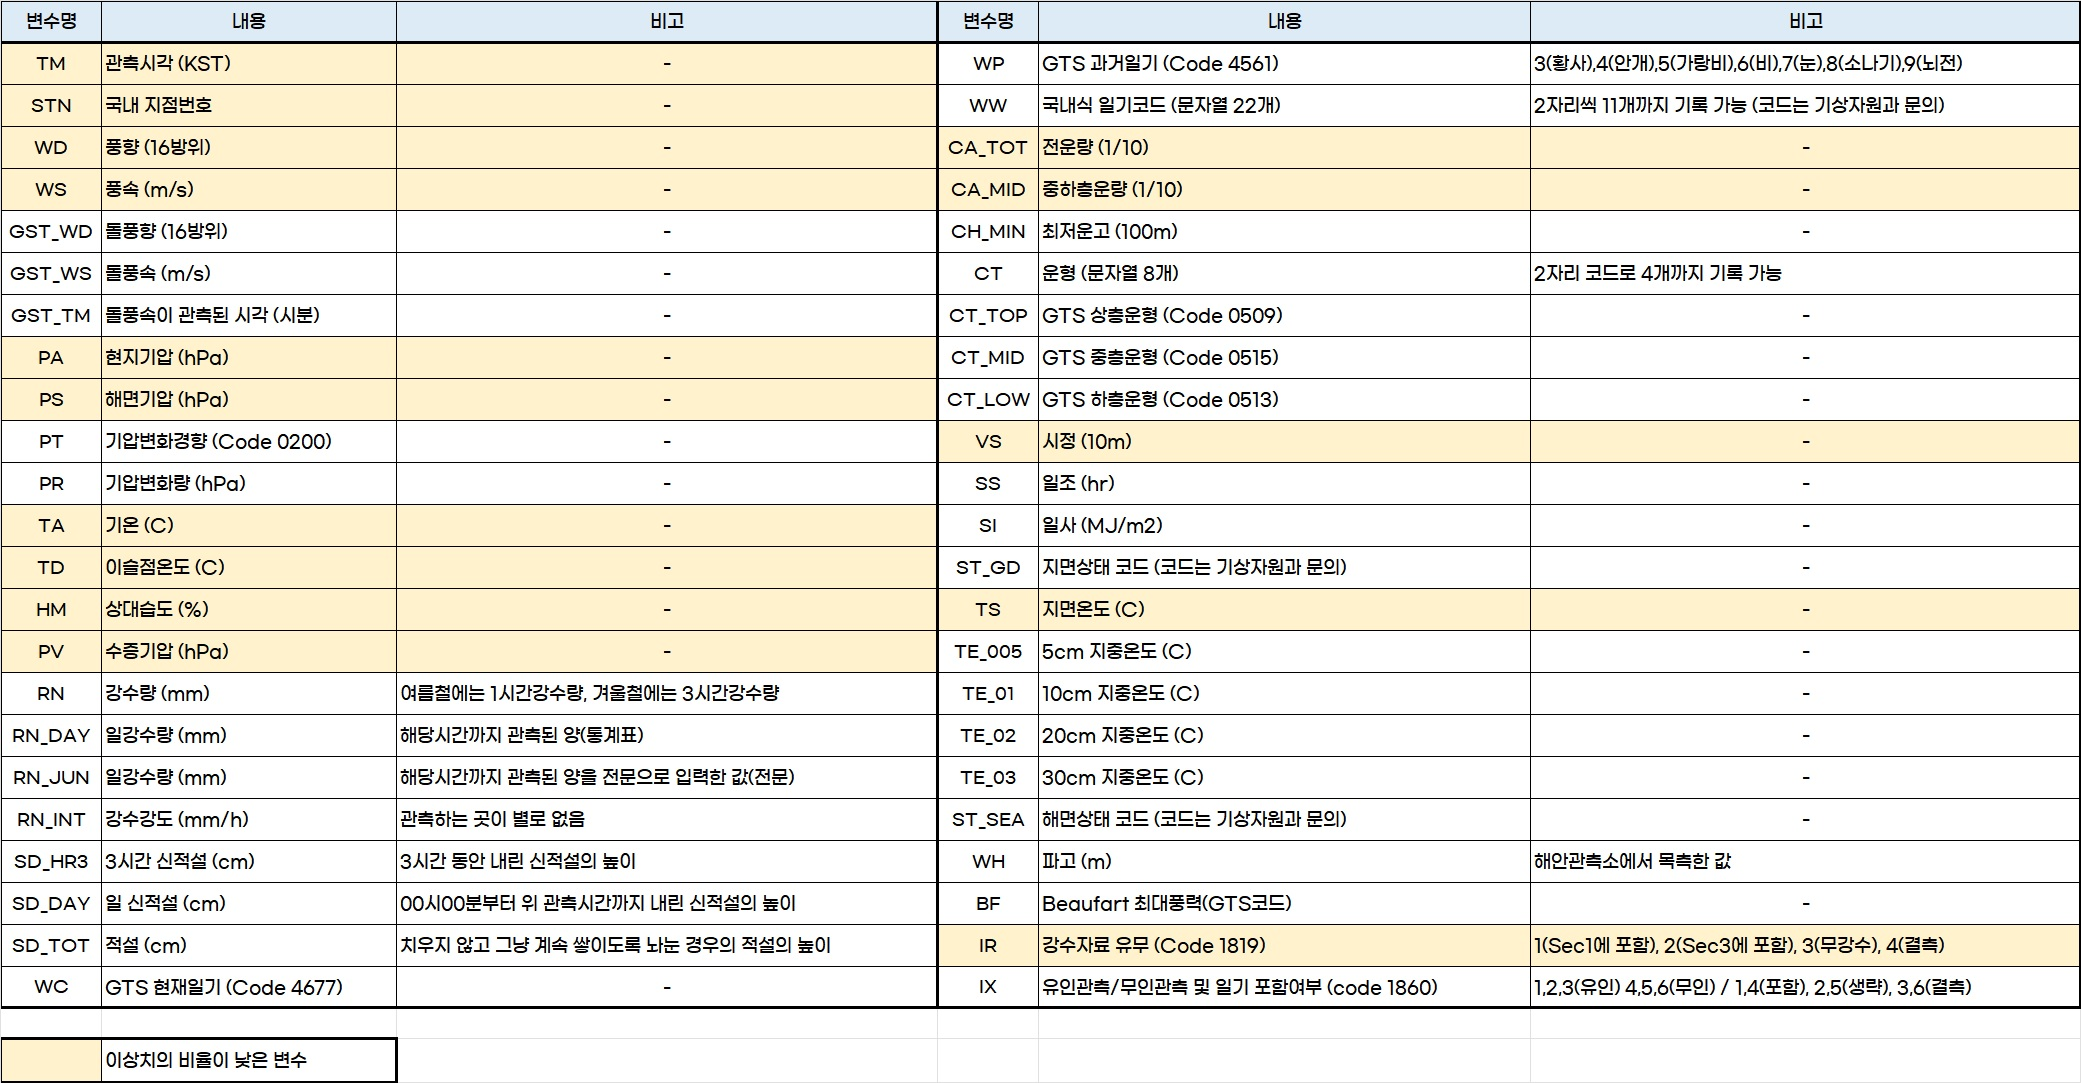

광역시, 특별시, 특별자치시 데이터 중 이상치의 비율이 낮은 특성 15개의 특성만 선택하여 프로젝트 진행에 활용

In [109]:
# 광역시, 특별시, 특별자치시 데이터 중  이상치(-9, -99, '-'의 비율이 낮은 변수 선택하여 Parquet 파일로 저장하기

available_column_list = list(available_column_list[:15]['variable'])
available_column_list.insert(0, 'datetime')
tmp = weather[available_column_list]
target_city_list = ['서울', '부산', '인천', '대구', '대전', '광주', '울산', '세종']
tmp = tmp[tmp['STN'].isin(target_city_list)]
tmp.to_parquet('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/available_weather_data.parquet')

## **전력 수급 데이터와 기상인자의 상관관계**

In [113]:
import pandas as pd
weather = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/available_weather_data.parquet')

* 기상인자의 대표값을 선정하기 위해서는 -9나 -99로 처리된 값을 어떻게 처리할 것인지를 확인해야 한다!
* 각 기상인자의 의미를 생각해보았을 때, 기온, 이슬점온도, 지면온도를 제외한 나머지 특성들은 -9나 -99의 값을 가진다는 것이 불가능하다. 즉, 이상치라고 보아도 무방하다.
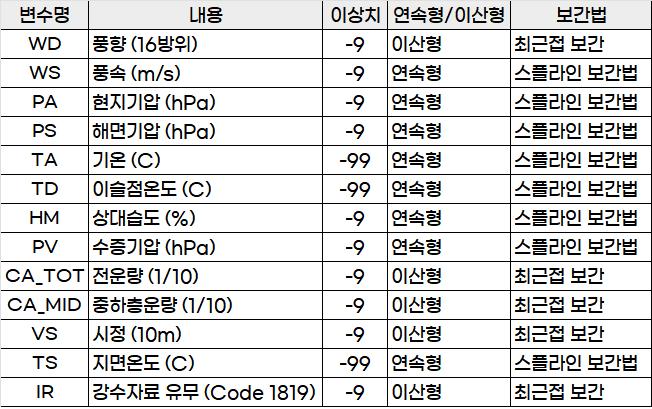

In [137]:
# 변수별로 -9, -99, '-'의 개수 확인하기

for column in list(weather.columns.values):
  a = len(weather[(weather[column]==-9)])
  b = len(weather[(weather[column]==-99)])
  c = len(weather[(weather[column]=='-')])
  print("{} \t\t -9의 개수 : {}개 \t -99의 개수 : {}개 \t '-'의 개수 : {}개".format(column, a, b, c))

datetime 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
STN_ID 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
STN 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
PS_hPa 		 -9의 개수 : 81개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
PA_hPa 		 -9의 개수 : 87개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
IR_nan 		 -9의 개수 : 666개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
CA_TOT 		 -9의 개수 : 94074개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
TA_C 		 -9의 개수 : 143개 	 -99의 개수 : 23개 	 '-'의 개수 : 0개
WS_m/s 		 -9의 개수 : 129개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
PV_hPa 		 -9의 개수 : 24개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
HM_% 		 -9의 개수 : 32개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
WD_16 		 -9의 개수 : 139개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
TS_C 		 -9의 개수 : 260개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
TD_C 		 -9의 개수 : 1170개 	 -99의 개수 : 27개 	 '-'의 개수 : 0개
VS_nan 		 -9의 개수 : 41888개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
CA_MID 		 -9의 개수 : 67684개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개


In [135]:
# 가장 가까운 -9나 -99가 아닌 값으로 대체되게끔 처리
from tqdm import tqdm
STN_list = list(weather['STN'].unique())
column_list = list(weather.columns.values)[3:]

for idx, STN in enumerate(tqdm(STN_list)):
  # ① 각 STN별로 데이터 나누기
  tmp = weather[weather['STN'] == STN]

  # ② 시간순으로 정렬하기
  tmp = tmp.sort_values(by='datetime')

  for column in column_list:
    # ③ -9나 -99인 값을 Null값으로 바꾸기

    if column in ['TA_C', 'TS_C', 'TD_C']:
      # 온도값은 -99가 Null값
      tmp.replace({column : {-99 : None}}, inplace = True)
    else:
      # 온도가 아닌 값은 -9가 Null값
      tmp.replace({column : {-9 : None}}, inplace = True)
                  
  for column in column_list:
    # ④ Pandas Interpolate로 보간법 사용하여 Null값 채우기
    if column in ['WD_16', 'CA_TOT', 'CA_MID', 'VS_nan', 'IR_nan']:
      # 이산형 변수는 최근접 이웃 보간법 사용
      tmp[column] = tmp[column].interpolate(method='nearest')
    else:
      # 연속형 변수는 선형 보간법 사용
      tmp[column] = tmp[column].interpolate(method='linear')
  # ⑤ tmp 합치기
  if idx == 0:
    interpolated_weather = tmp
  else:
    interpolated_weather = pd.concat([interpolated_weather, tmp])

100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


In [136]:
# 변수별로 -9, -99, '-'의 개수 확인하기

for column in list(interpolated_weather.columns.values):
  a = len(interpolated_weather[(interpolated_weather[column]==-9)])
  b = len(interpolated_weather[(interpolated_weather[column]==-99)])
  c = len(interpolated_weather[(interpolated_weather[column]=='-')])
  print("{} \t\t -9의 개수 : {}개 \t -99의 개수 : {}개 \t '-'의 개수 : {}개".format(column, a, b, c))

datetime 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
STN_ID 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
STN 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
PS_hPa 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
PA_hPa 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
IR_nan 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
CA_TOT 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
TA_C 		 -9의 개수 : 143개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
WS_m/s 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
PV_hPa 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
HM_% 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
WD_16 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
TS_C 		 -9의 개수 : 260개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
TD_C 		 -9의 개수 : 1170개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
VS_nan 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
CA_MID 		 -9의 개수 : 0개 	 -99의 개수 : 0개 	 '-'의 개수 : 0개
